# Predicting FIFA 23 Ultimate Team Player Card Values: A Machine Learning Approach

FIFA 23 is the latest version of the football video game series, developed by EA Sports. Ultimate Team is a popular game mode in the FIFA series, including FIFA 23, that allows players to create and manage their own football team using virtual player cards. The game mode is built around the concept of collecting and trading player cards, which represent real-world football players from different teams and leagues around the world. Players can use these cards to build their own custom teams, and compete against other players in online matches or tournaments.

In the FIFA 23 Ultimate Team Players Database, the "price" feature represents the current market price of a player card in the game's marketplace. The price is determined by a number of factors, including the player's real-world performance, rarity, popularity, and demand from other players. The price feature can be useful for players who want to buy or sell player cards strategically in order to build the strongest possible Ultimate Team.

In this portfolio notebook, I will demonstrate my skills in web scraping, data cleaning, and machine learning by building predictive models to estimate the market value of soccer player cards in FIFA 23's Ultimate Team mode. To do this, I will use web scraping techniques to extract player data from FUTBIN, a popular website for players of the game. I will then clean and preprocess the data to prepare it for modeling, using techniques such as data imputation, normalization, and feature selection. Finally, I will build and evaluate a range of machine learning models, including regression models, decision trees, and random forests, to predict the market value of different player cards based on their attributes and performance statistics.

## 1. Web Scraping Player Data from FUTBIN

FUTBIN is a popular website and mobile app that provides tools and resources for players of the Ultimate Team mode in FIFA 23 and other versions of the game. The website offers a comprehensive database of player cards, including their stats, ratings, and market values, as well as real-time updates on the prices of different cards in the game's virtual marketplace

### Import Libraries

In [3]:
# Data Manipulation

# Web Scraping
import requests
from bs4 import BeautifulSoup

# Time
from time import sleep

### Web Scraping Player Data from Page 1

In [2]:
# Define url and user-agent
url = 'https://www.futbin.com/players?page=1'
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36'

# Set the user agent string in the headers
headers = {
    'User-Agent': user_agent
}

# Make the request using the headers
response = requests.get(url, headers=headers)

# Parse the HTML content using Beautiful Soup
soup = BeautifulSoup(response.content, 'html.parser')

In [3]:
# Find stats for an example player
example = soup.find_all('tr')[0]

# Extract text from columns for player row
example_stats = [col.text.strip() for col in example.find_all('td')]
example_stats


['',
 'Pelé',
 '98',
 'CAM\nCF,ST',
 'Icon\n\n\r\n                                                    Explosive',
 '4.02M \n\n\n                                                                0.74%',
 '5',
 '4',
 'H \\ M',
 '95',
 '96',
 '93',
 '96',
 '60',
 '76',
 '173cm | 5\'8"\n  Unique  (70kg)',
 '3692',
 '516',
 '2513']

This data is missing the player's team, country and league which are in the form of hyperlinks. Therefore I will build a function to extract these values

In [4]:
def get_loc_attrs(row):
    attrs = []
    first_col = row.find_all('td')[1]
    for link in first_col.find_all('a')[1:4]:
        attr = link.get('data-original-title')
        attrs.append(attr)
    return attrs
    
# Test on example row
get_loc_attrs(example)

['FUT ICONS', 'Brazil', 'Icons']

I then build a function to extract the table headers:

In [5]:
def get_table_headers(soup):
    headers = []
    for header in soup.find_all('th')[2:]: # Start from third header as first two were in a different format
        header_title = header.find('a').get('data-original-title')
        if header_title[:8] == 'Order By': # Remove 'Order By' from header
            header_title = header_title[9:]
        headers.append(header_title)

    headers.insert(0, 'Name') # Add 'Name' to start of list as this wasn't added above
    headers.extend(['Team', 'Nation', 'League']) # Add other attributes not picked up above
    

    return headers

get_table_headers(soup)

['Name',
 'Rating',
 'Position',
 'Version',
 'Price',
 'Skills',
 'Weak Foot',
 'Attack \\ Defense',
 'Pace',
 'Shooting',
 'Passing',
 'Dribbling',
 'Defending',
 'Physicality',
 'Height',
 'Popularity',
 'Base Stats',
 'In Game Stats',
 'Team',
 'Nation',
 'League']

Next I build a function to create a dataframe of player attributes from the current page:

In [6]:
def players_df_from_onepage(soup):
    # Create an empty list to store all the player attributes
    all_players = []
    
    # Loop through each row in the table on the page
    for row in soup.find_all('tr'):
        cols = row.find_all('td')
        # Check if there are at least 2 columns (to skip blank lines or ads)
        if len(cols) > 1:
            # Extract the location attributes for the player from the row
            loc_attrs = get_loc_attrs(row)
            # Extract the other player attributes from the columns in the row
            other_attrs = [col.text.strip() for col in cols][1:] # Ignore first blank column
            # Combine and add to empty list
            player_attrs = other_attrs + loc_attrs
            all_players.append(player_attrs)

    # Get the table headers from the page
    headers = get_table_headers(soup)

    # Convert the list of player attributes to a pandas dataframe
    df = pd.DataFrame(all_players, columns=headers)
    
    # Rename the 'Attack \ Defense' column to 'Work Rate (Attack \ Defense)'
    df.rename(columns={'Attack \ Defense' : 'Work Rate (Attack \ Defense)'}, inplace=True)
    
    # Return the dataframe containing all the player attributes
    return df


In [7]:
df = players_df_from_onepage(soup)
df.head()

,Name,Rating,Position,Version,Price,Skills,Weak Foot,Work Rate (Attack \ Defense),Pace,Shooting,...,Dribbling,Defending,Physicality,Height,Popularity,Base Stats,In Game Stats,Team,Nation,League
0,Pelé,98,"CAM\nCF,ST",Icon\n\n\r\n ...,4.02M \n\n\n ...,5,4,H \ M,95,96,...,96,60,76,"173cm | 5'8""\n Unique (70kg)",3692,516,2513,FUT ICONS,Brazil,Icons
1,Lionel Messi,98,RW\nRM,TOTY\n\n\r\n ...,5M \n\n\n ...,4,4,H \ L,93,98,...,99,40,77,"169cm | 5'7""\n Messi (67kg)",5338,504,2469,Paris SG,Argentina,Ligue 1
2,Karim Benzema,97,CF\nST,TOTY\n\n\r\n ...,2.31M \n\n\n ...,4,5,H \ M,92,97,...,94,45,90,"185cm | 6'1""\n Average (81kg)",4291,508,2449,Real Madrid,France,LaLiga Santander
3,Kylian Mbappé,97,"ST\nCF,LW",TOTY\n\n\r\n ...,11.2M \n\n\n ...,5,4,H \ L,99,96,...,98,44,87,"182cm | 6'0""\n Unique (73kg)",3394,512,2455,Paris SG,France,Ligue 1
4,Kevin De Bruyne,97,CM\nCAM,TOTY\n\n\r\n ...,2.58M \n\n\n ...,4,5,H \ H,85,94,...,94,81,86,"181cm | 5'11""\n Unique (70kg)",2212,538,2593,Manchester City,Belgium,Premier League


### Web Scraping Player Data from All Pages

In [8]:
# Code to find the last page by web sraping the page navigation buttons below the table
last_page = int(soup.find_all('li', class_='page-item')[-2].find('a').text) 
print(last_page)

696


First I combine the steps from the previous section to create a function that creates a DataFrame for players on any given page:

In [9]:
def player_df_from_anypage(page_number):
    # Define url and user-agent
    url = 'https://www.futbin.com/players?page=' + str(page_number)
    user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36'

    # Set the user agent string in the headers
    headers = {
        'User-Agent': user_agent
    }

    # Make the request using the headers
    response = requests.get(url, headers=headers)

    # Parse the HTML content using Beautiful Soup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Call the previously defined function to create a DataFrame
    df = players_df_from_onepage(soup)

    # Return the dataframe containing all the player attributes
    return df

Next, I'll create a new function that iterates through each page of data, calls the `players_df_from_onepage` function for each page, and combines the resulting dataframes to create a complete dataset.

In [14]:
def get_dataset():
    
    # Define url and user-agent
    url = 'https://www.futbin.com/players?page=1'
    user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36'
    # Set the user agent string in the headers
    headers = {
        'User-Agent': user_agent
    }
    # Make the request using the headers
    response = requests.get(url, headers=headers)
    # Parse the HTML content using Beautiful Soup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Get the last page number
    last_page = int(soup.find_all('li', class_='page-item')[-2].find('a').text) 

    try:
        # create an empty pandas DataFrame to hold all the scraped data
        all_players = pd.DataFrame()
        
        # Loop through all pages to get all player data for that page and add to above dataframe 
        for i in range(1,last_page+1):
            df_i = player_df_from_anypage(i)
            all_players = pd.concat([all_players, df_i])
            
            # Sleep for 15 seconds every six requests to avoid too many requests
            if (i) % 6 == 0:
                sleep(15)        
            if i % 50 == 0:
                print(f'Page {i} scraped, {all_players.shape[0]} rows added')
    
    # If an error occurs, sleep for 30 seconds before continuing
    except requests.exceptions.RequestException as err:
            print(err)
            sleep(30)
    print('All pages scraped')

    return all_players

In [15]:
player_dataset = get_dataset()

Page 50 scraped, 1500 rows added
Page 100 scraped, 3000 rows added
Page 150 scraped, 4500 rows added
Page 200 scraped, 6000 rows added
Page 250 scraped, 7500 rows added
Page 300 scraped, 9000 rows added
Page 350 scraped, 10500 rows added
Page 400 scraped, 12000 rows added
Page 450 scraped, 13500 rows added
Page 500 scraped, 15000 rows added
Page 550 scraped, 16500 rows added
Page 600 scraped, 18000 rows added
Page 650 scraped, 19500 rows added
All pages scraped


In [16]:
player_dataset.to_csv(r'datasets\player_dataset.csv', index=False)

## 2. Cleaning the Dataset

### Import Libraries

In [43]:
import pandas as pd
import numpy as np

First I load the dataset and drop the 'Name' column:

In [44]:
df = pd.read_csv(r'datasets\player_dataset.csv')
df.drop('Name', axis=1, inplace=True)
df.head()

,Rating,Position,Version,Price,Skills,Weak Foot,Work Rate (Attack \ Defense),Pace,Shooting,Passing,Dribbling,Defending,Physicality,Height,Popularity,Base Stats,In Game Stats,Team,Nation,League
0,98,"CAM\nCF,ST",Icon\n\n\r\n ...,4.02M \n\n\n ...,5,4,H \ M,95,96,93,96,60,76,"173cm | 5'8""\n Unique (70kg)",3692,516,2513,FUT ICONS,Brazil,Icons
1,98,RW\nRM,TOTY\n\n\r\n ...,5M \n\n\n ...,4,4,H \ L,93,98,97,99,40,77,"169cm | 5'7""\n Messi (67kg)",5338,504,2469,Paris SG,Argentina,Ligue 1
2,97,CF\nST,TOTY\n\n\r\n ...,2.31M \n\n\n ...,4,5,H \ M,92,97,90,94,45,90,"185cm | 6'1""\n Average (81kg)",4291,508,2449,Real Madrid,France,LaLiga Santander
3,97,"ST\nCF,LW",TOTY\n\n\r\n ...,11.2M \n\n\n ...,5,4,H \ L,99,96,88,98,44,87,"182cm | 6'0""\n Unique (73kg)",3394,512,2455,Paris SG,France,Ligue 1
4,97,CM\nCAM,TOTY\n\n\r\n ...,2.58M \n\n\n ...,4,5,H \ H,85,94,98,94,81,86,"181cm | 5'11""\n Unique (70kg)",2212,538,2593,Manchester City,Belgium,Premier League


Next I change extract all of a player's positions and encode these values in additional columns:

In [45]:
# Change '/n' to commas
df['Position'] = df['Position'].apply(lambda x: ','.join(x.split()))
df['Position'].head()

0    CAM,CF,ST
1        RW,RM
2        CF,ST
3     ST,CF,LW
4       CM,CAM
Name: Position, dtype: object

In [46]:
# Code to extract a list of all unique positions
position_list = df['Position'].value_counts().index.values
nested_positions = [value.split(',') for value in position_list]
unique_positions = list(set([pos for sublist in nested_positions for pos in sublist]))
print(unique_positions)

['CB', 'RW', 'LW', 'RWB', 'LWB', 'CM', 'LB', 'GK', 'CAM', 'CF', 'CDM', 'LM', 'RB', 'RM', 'ST']


In [47]:
# We will save this as a csv file as we will need them later
pos_df = pd.DataFrame(unique_positions)
pos_df.to_csv(r'datasets\unique_positions.csv', index=False)

In [48]:
# Add additional columns for each position
for position in unique_positions:
    df[position] = 0
df.head()

,Rating,Position,Version,Price,Skills,Weak Foot,Work Rate (Attack \ Defense),Pace,Shooting,Passing,...,CM,LB,GK,CAM,CF,CDM,LM,RB,RM,ST
0,98,"CAM,CF,ST",Icon\n\n\r\n ...,4.02M \n\n\n ...,5,4,H \ M,95,96,93,...,0,0,0,0,0,0,0,0,0,0
1,98,"RW,RM",TOTY\n\n\r\n ...,5M \n\n\n ...,4,4,H \ L,93,98,97,...,0,0,0,0,0,0,0,0,0,0
2,97,"CF,ST",TOTY\n\n\r\n ...,2.31M \n\n\n ...,4,5,H \ M,92,97,90,...,0,0,0,0,0,0,0,0,0,0
3,97,"ST,CF,LW",TOTY\n\n\r\n ...,11.2M \n\n\n ...,5,4,H \ L,99,96,88,...,0,0,0,0,0,0,0,0,0,0
4,97,"CM,CAM",TOTY\n\n\r\n ...,2.58M \n\n\n ...,4,5,H \ H,85,94,98,...,0,0,0,0,0,0,0,0,0,0


In [49]:
# Populate the additional columns with ones if the player plays in that position
for i, entry in enumerate(df['Position']):
    positions = entry.split(',')
    for pos in positions:
        df.loc[i, pos] = 1

df.drop('Position', axis=1, inplace=True)
df.head()

,Rating,Version,Price,Skills,Weak Foot,Work Rate (Attack \ Defense),Pace,Shooting,Passing,Dribbling,...,CM,LB,GK,CAM,CF,CDM,LM,RB,RM,ST
0,98,Icon\n\n\r\n ...,4.02M \n\n\n ...,5,4,H \ M,95,96,93,96,...,0,0,0,1,1,0,0,0,0,1
1,98,TOTY\n\n\r\n ...,5M \n\n\n ...,4,4,H \ L,93,98,97,99,...,0,0,0,0,0,0,0,0,1,0
2,97,TOTY\n\n\r\n ...,2.31M \n\n\n ...,4,5,H \ M,92,97,90,94,...,0,0,0,0,1,0,0,0,0,1
3,97,TOTY\n\n\r\n ...,11.2M \n\n\n ...,5,4,H \ L,99,96,88,98,...,0,0,0,0,1,0,0,0,0,1
4,97,TOTY\n\n\r\n ...,2.58M \n\n\n ...,4,5,H \ H,85,94,98,94,...,1,0,0,1,0,0,0,0,0,0


Next I will remove '\n' from the Version column and split the two values into new columns:

In [50]:
' '.join(df.loc[3000, 'Version'].split()[0:-1])

'World Cup Player'

In [51]:
df['Card Type'] = df['Version'].apply(lambda x: ' '.join(x.split()[0:-1]))
df['Acceleration Type'] = df['Version'].apply(lambda x: x.split()[-1])
df.drop('Version', axis=1, inplace=True)

Next I will clean the Price column by removing '/n' and converting to floats:

In [52]:
# Remove '\n' and extract price
df['Price'] = df['Price'].apply(lambda x: x.split()[0])

In [53]:
# Funcction to convert string to float
def convert_string_to_number(value):
    if value[-1] == 'M':
        return float(value[:-1]) * 1000000
    elif value[-1] == 'K':
        return float(value[:-1]) * 1000
    else:
        return float(value)

# Apply function on Price column
df['Price'] = df['Price'].apply(convert_string_to_number)
df.head()


,Rating,Price,Skills,Weak Foot,Work Rate (Attack \ Defense),Pace,Shooting,Passing,Dribbling,Defending,...,GK,CAM,CF,CDM,LM,RB,RM,ST,Card Type,Acceleration Type
0,98,4020000.0,5,4,H \ M,95,96,93,96,60,...,0,1,1,0,0,0,0,1,Icon,Explosive
1,98,5000000.0,4,4,H \ L,93,98,97,99,40,...,0,0,0,0,0,0,1,0,TOTY,Controlled
2,97,2310000.0,4,5,H \ M,92,97,90,94,45,...,0,0,1,0,0,0,0,1,TOTY,Controlled
3,97,11200000.0,5,4,H \ L,99,96,88,98,44,...,0,0,1,0,0,0,0,1,TOTY,Controlled
4,97,2580000.0,4,5,H \ H,85,94,98,94,81,...,0,1,0,0,0,0,0,0,TOTY,Controlled


Next I will create two new columns from the Work Rate column:

In [54]:
# Create the new columns and drop the original
df['Work Rate (Attack)'] = df['Work Rate (Attack \ Defense)'].str.split().str[0]
df['Work Rate (Defense)'] = df['Work Rate (Attack \ Defense)'].str.split().str[2]
df.drop('Work Rate (Attack \ Defense)', axis=1, inplace=True)
df.head()

,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,CF,CDM,LM,RB,RM,ST,Card Type,Acceleration Type,Work Rate (Attack),Work Rate (Defense)
0,98,4020000.0,5,4,95,96,93,96,60,76,...,1,0,0,0,0,1,Icon,Explosive,H,M
1,98,5000000.0,4,4,93,98,97,99,40,77,...,0,0,0,0,1,0,TOTY,Controlled,H,L
2,97,2310000.0,4,5,92,97,90,94,45,90,...,1,0,0,0,0,1,TOTY,Controlled,H,M
3,97,11200000.0,5,4,99,96,88,98,44,87,...,1,0,0,0,0,1,TOTY,Controlled,H,L
4,97,2580000.0,4,5,85,94,98,94,81,86,...,0,0,0,0,0,0,TOTY,Controlled,H,H


Next I will extract the Height and Weight columns and convert to integers

In [55]:
df['Height (cm)'] = df['Height'].str.split().str[0].str[:-2]
df['Height (cm)'] = df['Height (cm)'].apply(lambda x: int(x) if pd.notnull(x) else np.nan)
df['Height (cm)'] = df['Height (cm)'].fillna(df['Height (cm)'].mean())

df['Weight (kg)'] = df['Height'].str.split().str[4].str[1:-3]
df['Weight (kg)'] = df['Weight (kg)'].apply(lambda x: int(x) if pd.notnull(x) and x != '' else np.nan)
df['Weight (kg)'] = df['Weight (kg)'].fillna(df['Weight (kg)'].mean())

df.drop('Height', axis=1, inplace=True)


We can ensure that all values are of the same case type by making every string value lowecase:

In [56]:
df = df.applymap(lambda x: x.lower() if type(x)==str else x)
df.head()

,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,LM,RB,RM,ST,Card Type,Acceleration Type,Work Rate (Attack),Work Rate (Defense),Height (cm),Weight (kg)
0,98,4020000.0,5,4,95,96,93,96,60,76,...,0,0,0,1,icon,explosive,h,m,173.0,70.0
1,98,5000000.0,4,4,93,98,97,99,40,77,...,0,0,1,0,toty,controlled,h,l,169.0,67.0
2,97,2310000.0,4,5,92,97,90,94,45,90,...,0,0,0,1,toty,controlled,h,m,185.0,81.0
3,97,11200000.0,5,4,99,96,88,98,44,87,...,0,0,0,1,toty,controlled,h,l,182.0,73.0
4,97,2580000.0,4,5,85,94,98,94,81,86,...,0,0,0,0,toty,controlled,h,h,181.0,70.0


Finally, we can remove any entries that have zero value as we are only interested in predicting players that are for sale in the marketplace: 

In [57]:
# Show the number of players with zero value
print('Number of rows:', df.shape[0])
print('Number of rows where Price equals 0:', (df['Price'] == 0).sum())

Number of rows: 20877
Number of rows where Price equals 0: 1718


In [58]:
# Remobe players with zero value
df = df[df['Price'] != 0]

In [59]:
# Re-run code to ensure values are removed
print('Number of rows:', df.shape[0])
print('Number of rows where Price equals 0:', (df['Price'] == 0).sum())

Number of rows: 19159
Number of rows where Price equals 0: 0


In [60]:
df.to_csv(r'datasets\player_dataset_clean.csv', index=False)

## 3. Exploratory Data Analysis

In [61]:
import pandas as pd
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=UserWarning)



In [62]:
df2 = pd.read_csv(r'datasets\player_dataset_clean.csv')
df2.head()

,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,LM,RB,RM,ST,Card Type,Acceleration Type,Work Rate (Attack),Work Rate (Defense),Height (cm),Weight (kg)
0,98,4020000.0,5,4,95,96,93,96,60,76,...,0,0,0,1,icon,explosive,h,m,173.0,70.0
1,98,5000000.0,4,4,93,98,97,99,40,77,...,0,0,1,0,toty,controlled,h,l,169.0,67.0
2,97,2310000.0,4,5,92,97,90,94,45,90,...,0,0,0,1,toty,controlled,h,m,185.0,81.0
3,97,11200000.0,5,4,99,96,88,98,44,87,...,0,0,0,1,toty,controlled,h,l,182.0,73.0
4,97,2580000.0,4,5,85,94,98,94,81,86,...,0,0,0,0,toty,controlled,h,h,181.0,70.0


### Replacing NaN values

First I will look to see if there are any NaN values in the dataset:

In [63]:
df2.isna().sum().sort_values(ascending=False).head()

Card Type    673
Rating         0
LM             0
CM             0
LB             0
dtype: int64

In [64]:
# Since Card Type has some NaN values, I will look into the value counts to see which are the most popular values
df2['Card Type'].value_counts().head()

Card Type
normal          14054
non-rare         1077
rare              666
libertadores      502
if                485
Name: count, dtype: int64

In [65]:
# Since 'normal' is by far the most common, I will opt to replace all NaN values with this value
df2['Card Type'] = df2['Card Type'].fillna('normal')

In [66]:
# Now I rerun this code to check that all NaN values have been ammended 
df2.isna().sum().sort_values(ascending=False).head()

Rating    0
RWB       0
CM        0
LB        0
GK        0
dtype: int64

### Target Variable Analysis

We will now look into our target variable Price. For this stage we will split out data into a train and test sets and only do anaylysis on the training set in order to avoid any data leakage. 


In [67]:
# Train Test Split
df_train, df_test = train_test_split(
    df2, test_size=0.3, random_state=42
)

# Save datasets
df_train.to_csv(r'datasets\train_dataset.csv', index=False)
df_test.to_csv(r'datasets\test_dataset.csv', index=False)

Skew value of Price = 29.08


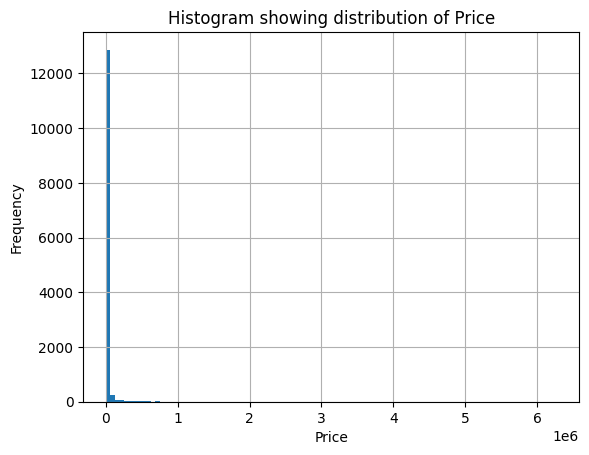

In [68]:
df_train.Price.hist(bins=100)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram showing distribution of Price');
print(f'Skew value of Price = {df.Price.skew():.2f}')

We can see here that the Price column is heavily skewed. This makes sense as the rarer players in the game are generally the most sought after and therefore are worth the most. We can see below that a significant proportion of these are players priced at below 1000 coins:

In [69]:
# Number of players at each price point below 1000
below_5000_counts = df_train[df_train['Price']<5000]['Price'].value_counts().head(20)
print(below_5000_counts.head(10))
below_5000_proportion = (below_5000_counts.sum()/df_train.shape[0])*100
print('\n')
print(f'{below_5000_proportion:.2f}% of all entries are below 5000 coins')

Price
400.0     3735
200.0     3502
450.0      731
500.0      335
350.0      278
850.0      227
1000.0     216
900.0      204
550.0      201
600.0      180
Name: count, dtype: int64


81.13% of all entries are below 5000 coins


Realistically, anything below 5000 coins is a small amount of money in the game and can be easily afforded by most gamers. The model should allow users to identify value in the marketplace so this model would be better built to predict higher valued players. Therefore, I will look into ways to reduce the dataset so that a significant propotion of these lower-valued players are removed. 

Generally players with a higher Rating are worth the most in the game so we can look into whether removing lower rated players can help us reduce the lower-valued players in the dataset:

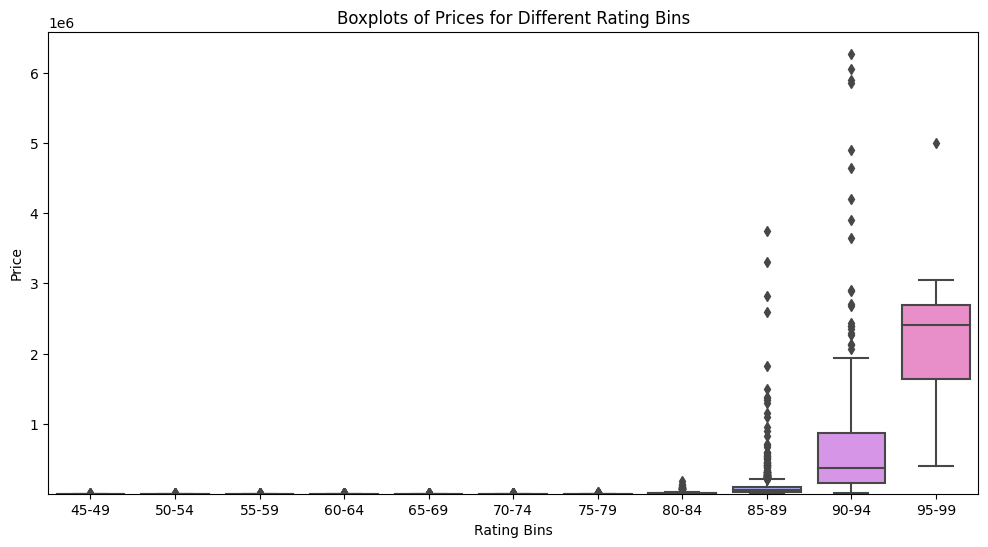

In [70]:
# Create bins for the Rating column
bins = range(45, 105, 5)
labels = [f'{i}-{i+4}' for i in range(45,96,5)]
df_train_bins= pd.cut(df_train["Rating"], bins=bins, labels=labels)

# Create boxplots for Price for each of these bins
fig, ax = plt.subplots(figsize = (12,6))

sns.boxplot(x=df_train_bins, y=df_train['Price'], ax=ax)

ax.set_xlabel('Rating Bins')
ax.set_ylabel('Price')
ax.set_ylim(5000)
ax.set_title('Boxplots of Prices for Different Rating Bins');

From the above graph we can see that we definitely want to include all players with a Rating over 90 in our model. However, we can also look deeper into the players with a rating below 90 to see if it's worth keeping any of these in our dataset. 

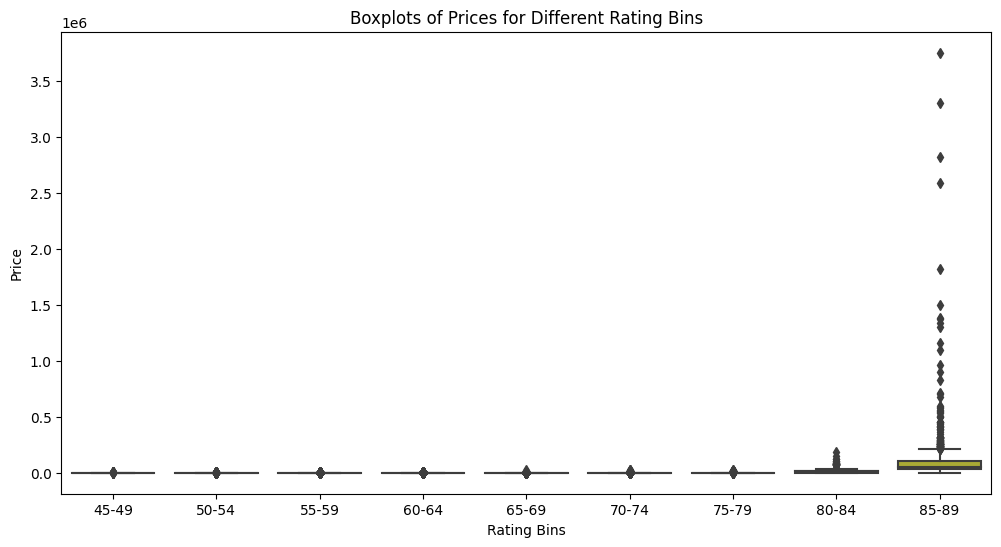

In [71]:
# Create bins for the Rating column
bins = range(45, 95, 5)
labels = [f'{i}-{i+4}' for i in range(45,86,5)]
df_train_bins= pd.cut(df_train["Rating"], bins=bins, labels=labels)

# Create boxplots for Price for each of these bins
fig, ax = plt.subplots(figsize = (12,6))

sns.boxplot(x=df_train_bins, y=df_train['Price'], ax=ax)

ax.set_xlabel('Rating Bins')
ax.set_ylabel('Price')
ax.set_title('Boxplots of Prices for Different Rating Bins');

In [72]:
# We can also see the number of player priced over 5000 for each bin
num_players_over_5000 = df_train[df_train['Price'] > 5000].groupby(df_train_bins)['Price'].count()
print(num_players_over_5000)

Rating
45-49      7
50-54     19
55-59     40
60-64     80
65-69     44
70-74     29
75-79     72
80-84    337
85-89    703
Name: Price, dtype: int64


We can look into the Card Type for players that are rated below 85 as generally special edition cards are worth more:

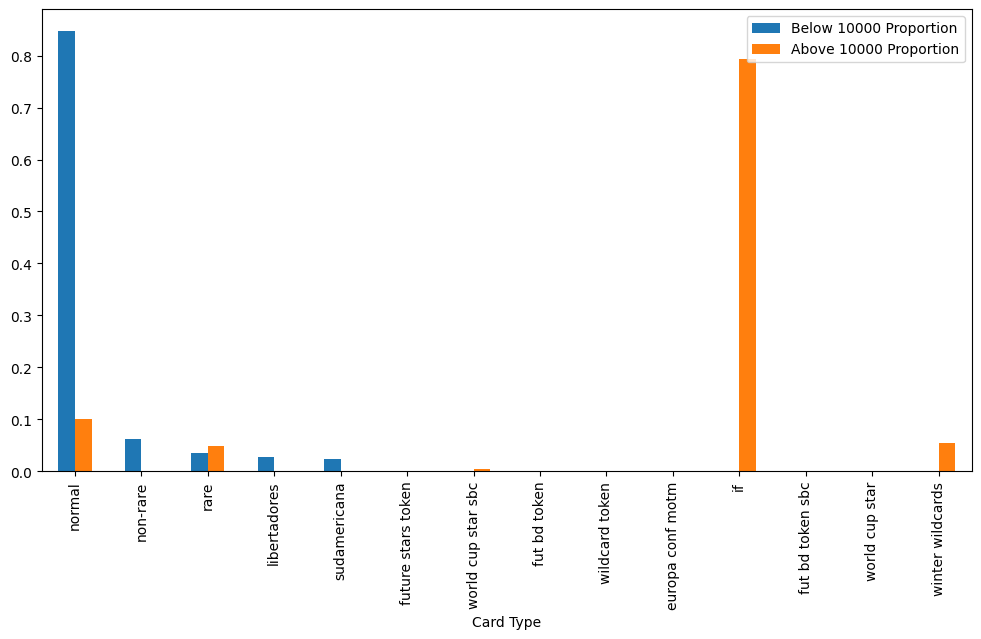

In [73]:
# Create new dataframes for players rated below 80 for both over and under 1000 coins
df_below85_above10000 = df_train[(df_train['Rating'] < 90) & (df_train['Price'] > 10000)]
df_below85_below10000 = df_train[(df_train['Rating'] < 90) & (df_train['Price'] < 10000)]

# Creare additional new dataframes counting the different Card Types for both of the above dataframes
df_below85_above10000_count = pd.DataFrame(df_below85_above10000['Card Type'].value_counts()).reset_index()
df_below85_below10000_count = pd.DataFrame(df_below85_below10000['Card Type'].value_counts()).reset_index()

# Merge the dataframes on Card Type and rename the columns 
card_types = df_below85_above10000_count.merge(df_below85_below10000_count, how='right', on='Card Type')
card_types.rename({'count_x' : 'Above 10000 Count', 'count_y' : 'Below 10000 Count'}, axis=1, inplace=True)

# Fill NaN values with 0 and create new columns for the proportions 
card_types.fillna(0, inplace=True)
card_types['Above 10000 Proportion'] = card_types['Above 10000 Count'].apply(lambda x: x/card_types['Above 10000 Count'].sum())
card_types['Below 10000 Proportion'] = card_types['Below 10000 Count'].apply(lambda x: x/card_types['Below 10000 Count'].sum())

# Plot in a bar graph
fig, ax = plt.subplots(figsize = (12,6))
card_types.plot(x='Card Type', y = ['Below 10000 Proportion', 'Above 10000 Proportion'], kind='bar', ax=ax)
plt.legend(loc='upper right');

Based on the information presented in the graph, it would be prudent to exclude 'normal', 'non-rare', 'libertadores' and 'sudamerica' cards from the dataset, as they represent a disproportionately higher proportion of cards that are valued at less than 10000 coins.

To simplify the analysis, we will also exclude 'rare' cards, since these, along with the aforementioned types, are the only non-special cards. As such, our model will focus on predicting the value of player cards with a rating of 90 or higher, as well as special cards with a rating below 90.

Since we are redefining the purpose of the model, we will remove these values from both the train and test dataset:

In [74]:
df_train2 = df_train[(df_train['Rating'] >= 90) | ~(df_train['Card Type'].isin(['normal', 'non-rare', 'rare', 'libertadores','sudamericana']))]
df_test2 = df_test[(df_test['Rating'] >= 90) | ~(df_test['Card Type'].isin(['normal', 'non-rare', 'rare', 'libertadores','sudamericana']))]

print('Old number of rows:', (df_train.shape[0] + df_test.shape[0]))
print('New number of rows:', (df_train2.shape[0] + df_test2.shape[0]))
print('\n')
print('Old skew value of Price column:', df_train['Price'].skew().round(2))
print('New skew value of Price column:', df_train2['Price'].skew().round(2))

# Save datasets
df_train2.to_csv(r'datasets\train_dataset.csv', index=False)
df_test2.to_csv(r'datasets\test_dataset.csv', index=False)

Old number of rows: 19159
New number of rows: 1780


Old skew value of Price column: 19.12
New skew value of Price column: 5.92


Our target column for our training dataset is still heavily skewed so we will remove some outliers. However, we will only remove these from the training dataset to avoid data leakage:

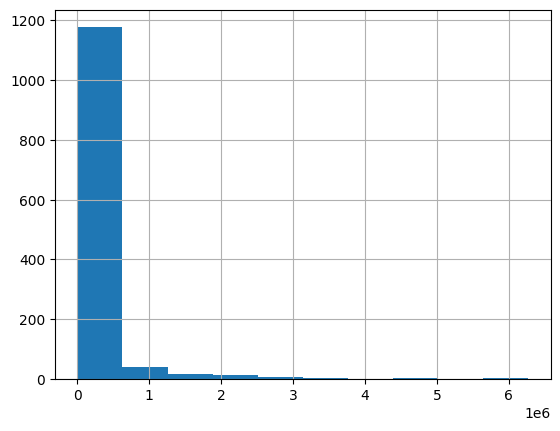

In [75]:
# Plot a histogram
df_train2.Price.hist();

In [76]:
# Overwrite the saved dataset
df_train2.to_csv(r'datasets\train_dataset.csv', index=False)

### Categorical Feature Analysis

Now we will do some analysis into the categorical columns:

In [77]:
# Load data
df_train = pd.read_csv(r'datasets\train_dataset.csv')
df_test = pd.read_csv(r'datasets\test_dataset.csv')

In [78]:
cat_df = df_train.select_dtypes(include='object')
cat_df.head()

,Team,Nation,League,Card Type,Acceleration Type,Work Rate (Attack),Work Rate (Defense)
0,zagłębie lubin,bosnia and herzegovina,polski ekstraklasa (pol 1),if,controlled,m,m
1,rcd espanyol,spain,laliga santander,sif,lengthy,h,m
2,ajax,netherlands,eredivisie,if,controlled,m,m
3,rennes,belgium,ligue 1,if,explosive,h,m
4,fut icons,france,icons,icon,controlled,m,m


First I will look into the Work Rate columns:

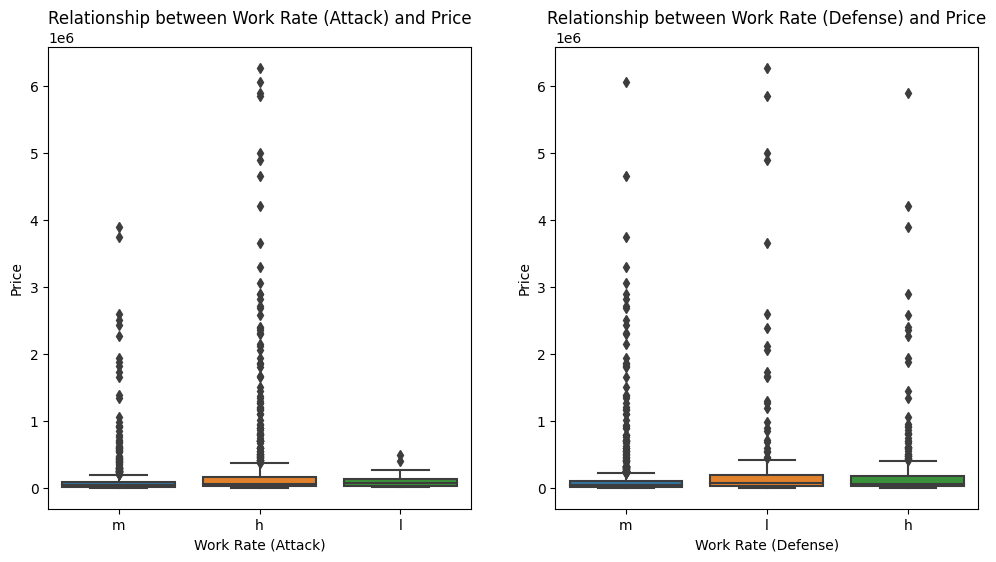

In [79]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

sns.boxplot(x='Work Rate (Attack)', y='Price', data=df_train, ax=ax1)
ax1.set_xlabel('Work Rate (Attack)')
ax1.set_ylabel('Price')
ax1.set(title='Relationship between Work Rate (Attack) and Price')

sns.boxplot(x='Work Rate (Defense)', y='Price', data=df_train, ax=ax2)
ax2.set_xlabel('Work Rate (Defense)')
ax2.set(title='Relationship between Work Rate (Defense) and Price');

Although our target variable Price is still fairly heavily skewed, there seems to be a clear correlation with 'Work Rate (Attack)' and 'Price' but not so much with 'Work Rate (Defense)' and 'Price'. However, since we can ordinal encode this columns, we will keep both for now as we won't be adding any additional columns:

In [80]:
# Create encoder object
encoder = OrdinalEncoder(categories=[['l', 'm', 'h']], handle_unknown='use_encoded_value', unknown_value=4)

# Fit and transorm on train data and transform test data - Attack
df_train['WR_Att_OE'] = encoder.fit_transform(df_train[['Work Rate (Attack)']])
df_test['WR_Att_OE'] = encoder.fit_transform(df_test[['Work Rate (Attack)']])

# Fit and transorm on train data and transform test data - Defense
df_train['WR_Def_OE'] = encoder.fit_transform(df_train[['Work Rate (Defense)']])
df_test['WR_Def_OE'] = encoder.fit_transform(df_test[['Work Rate (Defense)']])

# Drop original columns
df_train.drop(['Work Rate (Attack)', 'Work Rate (Defense)'], axis=1, inplace=True)
df_test.drop(['Work Rate (Attack)', 'Work Rate (Defense)'], axis=1, inplace=True)


In [81]:
cat_df = df_train.select_dtypes(include='object')
cat_df.head()

,Team,Nation,League,Card Type,Acceleration Type
0,zagłębie lubin,bosnia and herzegovina,polski ekstraklasa (pol 1),if,controlled
1,rcd espanyol,spain,laliga santander,sif,lengthy
2,ajax,netherlands,eredivisie,if,controlled
3,rennes,belgium,ligue 1,if,explosive
4,fut icons,france,icons,icon,controlled


Next we will look into 'Acceleration Type':

In [82]:
df_train['Acceleration Type'].value_counts()

Acceleration Type
controlled    726
explosive     299
lengthy       242
Name: count, dtype: int64

Since there are only three different values here, it will be fine to one-hot encode these without adding too many new columns

We will create a function that one-hot-encodes our feature, adds the columns onto the original dataset, and deletes the orginal feature

In [83]:
def add_ohe_columns(df_train, df_test, column):
    
    # Create OHE object
    ohe = OneHotEncoder(handle_unknown='ignore')

    # Fit and transform train data
    ohe.fit(df_train[[column]])
    ohe_cols_train = ohe.transform(df_train[[column]])
    ohe_df_train = pd.DataFrame(ohe_cols_train.toarray(), columns=ohe.get_feature_names_out())

    # Concatenate with orgiginal dataframe and drop old column
    new_df_train = pd.concat([df_train, ohe_df_train], axis=1)
    new_df_train.drop(column, axis=1, inplace=True)

    # Transform test data
    ohe_cols_test = ohe.transform(df_test[[column]])
    ohe_df_test = pd.DataFrame(ohe_cols_test.toarray(), columns=ohe.get_feature_names_out())

    # Concatenate with orgiginal dataframe and drop old column
    new_df_test = pd.concat([df_test, ohe_df_test], axis=1)
    new_df_test.drop(column, axis=1, inplace=True)

    # Return new dataframe
    return new_df_train, new_df_test


In [84]:
df_train

,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,LM,RB,RM,ST,Card Type,Acceleration Type,Height (cm),Weight (kg),WR_Att_OE,WR_Def_OE
0,79,11750.0,1,2,79,79,75,79,41,80,...,0,0,0,0,if,controlled,193.0,72.794708,1.0,1.0
1,86,19750.0,3,3,70,87,76,82,38,81,...,0,0,0,1,sif,lengthy,192.0,72.794708,2.0,1.0
2,81,16250.0,1,4,80,83,88,83,49,82,...,0,0,0,0,if,controlled,187.0,72.794708,1.0,1.0
3,83,11000.0,4,3,95,75,76,88,35,74,...,0,0,1,0,if,explosive,171.0,60.000000,2.0,1.0
4,93,670000.0,4,4,94,91,83,90,53,80,...,0,0,0,1,icon,controlled,188.0,72.794708,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,85,75000.0,3,4,91,86,66,79,40,74,...,0,0,0,1,icon,controlled,175.0,72.000000,1.0,1.0
1263,91,469000.0,3,4,87,84,86,77,89,82,...,0,0,1,0,icon,controlled,174.0,70.000000,2.0,2.0
1264,88,35500.0,3,4,83,88,78,80,40,84,...,0,0,0,1,if,lengthy,191.0,94.000000,1.0,0.0
1265,83,12500.0,2,3,67,51,68,73,83,90,...,0,0,0,0,if,lengthy,190.0,72.794708,1.0,2.0


In [85]:
# OHE 'Acceleration Type
df_train, df_test = add_ohe_columns(df_train, df_test, 'Acceleration Type')

# Check to see columns have successfully been encoded
display(df_train.head(2))
display(df_test.head(2))

,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,RM,ST,Card Type,Height (cm),Weight (kg),WR_Att_OE,WR_Def_OE,Acceleration Type_controlled,Acceleration Type_explosive,Acceleration Type_lengthy
0,79,11750.0,1,2,79,79,75,79,41,80,...,0,0,if,193.0,72.794708,1.0,1.0,1.0,0.0,0.0
1,86,19750.0,3,3,70,87,76,82,38,81,...,0,1,sif,192.0,72.794708,2.0,1.0,0.0,0.0,1.0


,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,RM,ST,Card Type,Height (cm),Weight (kg),WR_Att_OE,WR_Def_OE,Acceleration Type_controlled,Acceleration Type_explosive,Acceleration Type_lengthy
0,90,120000.0,1,3,88,87,80,90,53,91,...,0,0,world cup icon,196.0,72.794708,1.0,1.0,1.0,0.0,0.0
1,87,26500.0,4,3,80,80,87,90,49,72,...,0,0,if,180.0,81.000000,2.0,1.0,1.0,0.0,0.0


In [86]:
df_train.columns

Index(['Rating', 'Price', 'Skills', 'Weak Foot', 'Pace', 'Shooting', 'Passing',
       'Dribbling', 'Defending', 'Physicality', 'Popularity', 'Base Stats',
       'In Game Stats', 'Team', 'Nation', 'League', 'CB', 'RW', 'LW', 'RWB',
       'LWB', 'CM', 'LB', 'GK', 'CAM', 'CF', 'CDM', 'LM', 'RB', 'RM', 'ST',
       'Card Type', 'Height (cm)', 'Weight (kg)', 'WR_Att_OE', 'WR_Def_OE',
       'Acceleration Type_controlled', 'Acceleration Type_explosive',
       'Acceleration Type_lengthy'],
      dtype='object')

In [87]:
cat_df = df_train.select_dtypes(include='object')
cat_df.head()

,Team,Nation,League,Card Type
0,zagłębie lubin,bosnia and herzegovina,polski ekstraklasa (pol 1),if
1,rcd espanyol,spain,laliga santander,sif
2,ajax,netherlands,eredivisie,if
3,rennes,belgium,ligue 1,if
4,fut icons,france,icons,icon


Next we look into the Card Type column. Since there are a lot of values in this column we will find ways to group some of them together.

In [88]:
# Show number of unique values
print('Number of unique Card Type values:', df_train['Card Type'].nunique())

Number of unique Card Type values: 80


In [89]:
# Return a list of Card Type values
df_train['Card Type'].value_counts().index

Index(['if', 'icon', 'sif', 'hero', 'fut future stars', 'winter wildcards',
       'fut centurions', 'fut birthday', 'world cup ptg', 'world cup icon',
       'fantasy', 'normal', 'trophy titans - icon', 'world cup hero',
       'showdown sbc', 'world cup phenoms', 'world cup showdown s',
       'world cup stories', 'world cup tott', 'flashback sbc', 'rulebreakers',
       'fantasy hero', 'motm', 'road to world cup', 'dynamic duos',
       'world cup star sbc', 'ucl live', 'toty', 'fut birthday sbc',
       'future stars token', 'winter wildcards sbc', 'fut bd token', 'otw',
       'toty honourable ment', 'tif', 'champions league', 'out of position',
       'toty icon', 'trophy titans hero', 'fut ballers sbc',
       'player moments sbc', 'potm serie a sbc', 'out of position sbc',
       'fut centurions sbc', 'uel live', 'pl potm sbc', 'wildcard token',
       'fut future stars sbc', 'eredivisie potm sbc', 'ligue 1 potm sbc',
       'cl motm', 'laliga potm sbc', 'otw sbc', 'europa leag

First we can create a function for replacing values containing certain strings with another value:

In [90]:
def replace_cat_values(df_train, df_test, column, old_values, new_value):
    
    # Create copies of the dataframes 
    new_df_train = df_train.copy()
    new_df_test = df_test.copy()

    # Convert old_values to a string, if it is a list, for use in str.contains()
    if type(old_values) == str:
        string = old_values
    elif type(old_values) == list:
        string = '|'.join(old_values)
        
    # Create a mask of rows where the column contains any of the old values
    train_mask = new_df_train[column].str.contains(string)
    test_mask = new_df_test[column].str.contains(string)

    # Replace the old values with the new value in the selected rows
    new_df_train.loc[train_mask, column] = new_value
    new_df_test.loc[test_mask, column] = new_value

    # Return new df
    return new_df_train, new_df_test



We can group all SBC, MOTM, Icon, Hero, Token and IF cards: 

In [91]:
# SBC (We use 'sb' as one value is missing the 'c')
df_train, df_test = replace_cat_values(df_train, df_test, 'Card Type', 'sb', 'sbc')

# MOTM
df_train, df_test = replace_cat_values(df_train, df_test, 'Card Type', 'motm', 'motm')

# Icon
df_train, df_test = replace_cat_values(df_train, df_test, 'Card Type', 'icon', 'icon')

# Hero
df_train, df_test = replace_cat_values(df_train, df_test, 'Card Type', 'hero', 'hero')

# Token
df_train, df_test = replace_cat_values(df_train, df_test, 'Card Type', 'token', 'token')

# IF
df_train, df_test = replace_cat_values(df_train, df_test, 'Card Type', 'if', 'if')

# Show updated number of unique values
print('Number of unique Card Type values:', df_train['Card Type'].nunique())
# Return an updated list of Card Type values
df_train['Card Type'].value_counts().index

Number of unique Card Type values: 33


Index(['if', 'icon', 'sbc', 'hero', 'fut future stars', 'winter wildcards',
       'fut centurions', 'fut birthday', 'world cup ptg', 'fantasy', 'motm',
       'token', 'normal', 'world cup showdown s', 'world cup phenoms',
       'rulebreakers', 'world cup stories', 'world cup tott', 'ucl live',
       'dynamic duos', 'road to world cup', 'toty', 'champions league', 'otw',
       'out of position', 'toty honourable ment', 'uel live',
       'conference league', 'world cup showdown', 'world cup star',
       'uecl live', 'europa league', 'rare'],
      dtype='object', name='Card Type')

Next we'll group all the tournament cards together:

In [92]:
# World Cup
df_train, df_test = replace_cat_values(df_train, df_test, 'Card Type', 'world cup', 'world cup')

# UEFA Cup competitions
df_train, df_test = replace_cat_values(df_train, df_test, 'Card Type', ['ucl','uel','uecl','champions league','europa league','conference league'], 'uefa cup comps')

# South America competitions
df_train, df_test = replace_cat_values(df_train, df_test, 'Card Type', ['sudamericana','libertadores'], 'south america comps')

# Show updated number of unique values
print('Number of unique Card Type values:', df_train['Card Type'].nunique())
# Return an updated list of Card Type values
df_train['Card Type'].value_counts().index

Number of unique Card Type values: 21


Index(['if', 'icon', 'sbc', 'world cup', 'hero', 'fut future stars',
       'winter wildcards', 'fut centurions', 'uefa cup comps', 'fut birthday',
       'fantasy', 'token', 'motm', 'normal', 'rulebreakers', 'dynamic duos',
       'toty', 'toty honourable ment', 'out of position', 'otw', 'rare'],
      dtype='object', name='Card Type')

We can also group Normal, Rare and Non-Rare cards together as these generally all the non-special cards in the game:

In [93]:
df_train, df_test = replace_cat_values(df_train, df_test, 'Card Type', ['normal','rare','non-rare'], 'non-special')

# Show updated number of unique values
print('Number of unique Card Type values:', df_train['Card Type'].nunique())
# Return an updated list of Card Type values
df_train['Card Type'].value_counts().index

Number of unique Card Type values: 20


Index(['if', 'icon', 'sbc', 'world cup', 'hero', 'fut future stars',
       'winter wildcards', 'fut centurions', 'uefa cup comps', 'fut birthday',
       'fantasy', 'non-special', 'motm', 'token', 'rulebreakers',
       'dynamic duos', 'toty', 'otw', 'out of position',
       'toty honourable ment'],
      dtype='object', name='Card Type')

We will now look into the median Price values of the new Card Type values:  

In [94]:
df_train.groupby('Card Type')['Price'].median().sort_values(ascending=False)

Card Type
toty                    2095000.0
non-special              304000.0
toty honourable ment     157000.0
icon                     115000.0
fut future stars          79500.0
sbc                       74950.0
fut birthday              74000.0
uefa cup comps            63500.0
world cup                 58000.0
hero                      58000.0
fantasy                   53500.0
winter wildcards          40375.0
otw                       40250.0
fut centurions            34500.0
rulebreakers              31375.0
dynamic duos              29150.0
out of position           28000.0
motm                      17500.0
if                        16500.0
token                      3550.0
Name: Price, dtype: float64

We can see above that apart from TOTY and TOTY Honourable Mention, all the other card types are on a similar scale, therefore we will create an 'Other' category for the remaining types that weren't grouped earlier: 

In [95]:
# Get a list of card types not already grouped
all_types = df_train['Card Type'].value_counts().index.to_list()
replaced_types = ['icon', 'south america comps', 'sbc', 'uefa cup comps', 'world cup', 'hero', 'motm', 'if']
to_replace_types = [type for type in all_types if type not in replaced_types]

# Replace these with 'other'
df_train, df_test = replace_cat_values(df_train, df_test, 'Card Type', to_replace_types, 'other') 

# Show updated number of unique values
print('Number of unique Card Type values:', df_train['Card Type'].nunique())
# Return an updated list of Card Type values
df_train['Card Type'].value_counts().index

Number of unique Card Type values: 8


Index(['if', 'icon', 'other', 'sbc', 'world cup', 'hero', 'uefa cup comps',
       'motm'],
      dtype='object', name='Card Type')

Now that we just have significantly reduced our unique values for this feature, we can one-hot-encode it without adding too many additional features.

In [96]:
# OHE 'Acceleration Type
df_train, df_test = add_ohe_columns(df_train, df_test, 'Card Type')

# Check to see columns have successfully been encoded
display(df_train.head(2))
display(df_test.head(2))

,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,Acceleration Type_explosive,Acceleration Type_lengthy,Card Type_hero,Card Type_icon,Card Type_if,Card Type_motm,Card Type_other,Card Type_sbc,Card Type_uefa cup comps,Card Type_world cup
0,79,11750.0,1,2,79,79,75,79,41,80,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,86,19750.0,3,3,70,87,76,82,38,81,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,Acceleration Type_explosive,Acceleration Type_lengthy,Card Type_hero,Card Type_icon,Card Type_if,Card Type_motm,Card Type_other,Card Type_sbc,Card Type_uefa cup comps,Card Type_world cup
0,90,120000.0,1,3,88,87,80,90,53,91,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,87,26500.0,4,3,80,80,87,90,49,72,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [97]:
cat_df = df_train.select_dtypes(include='object')
cat_df.head()

,Team,Nation,League
0,zagłębie lubin,bosnia and herzegovina,polski ekstraklasa (pol 1)
1,rcd espanyol,spain,laliga santander
2,ajax,netherlands,eredivisie
3,rennes,belgium,ligue 1
4,fut icons,france,icons


We will now look into the League column:

In [98]:
# Show number of unique values
print('Number of unique League values:', df_train['League'].nunique())

# Return an updated list of League values
league_names = df_train['League'].value_counts().index
print(league_names)

Number of unique League values: 44
Index(['icons', 'premier league', 'serie a tim', 'laliga santander',
       'bundesliga', 'ligue 1', 'major league soccer', 'eredivisie',
       'liga nos (por 1)', 'süper lig (tur 1)', 'efl championship (eng 2)',
       '1a pro league (bel 1)', 'mbs pro league (sau 1)',
       'scottish premiership (spfl)', '3. liga (ger 3)',
       'efl league two (eng 4)', 'bundesliga 2 (ger 2)',
       'raiffeisen super l. (sui 1)', 'a-league (aus 1)', 'world cup',
       'ligue 2 (fra 2)', 'allsvenskan (swe 1)', 'italy serie b (2)',
       'indian super league (ind 1)', 'primera división (arg 1)',
       'polski ekstraklasa (pol 1)', 'laliga smartbank (esp 2)',
       'efl league one (eng 3)', 'ö bundesliga (aut 1)',
       '3f superliga (den 1)', 'ukrayina liha (ukr 1)', 'česká liga (cze 1)',
       'liga i (rom 1)', 'south african fl (rsa 1)', 'hellas liga (gre 1)',
       'liga hrvatska (cro 1)', 'conmebol libertadores',
       'chinese fa super l. (chn 1)', '

We will keep all the big 5 European leagues as their own columns as well as MLS and special categories such as Icons and World Cup. For the rest we will group by division and continent. 

In [99]:
# Big 5 league's lower divisions:
big5_low_divs = [league[:league.find('(')] for league in league_names if league[-2] in ['2','3','4','5']]
df_train, df_test = replace_cat_values(df_train, df_test, 'League', big5_low_divs, 'big5_low_div')

# South American Divisions:
df_train, df_test = replace_cat_values(df_train, df_test, 'League', ['conmebol libertadores', 'conmebol sudamericana', 'primera división (arg 1)'], 'sa_leagues')

# Asian and Australian Divisions:
df_train, df_test = replace_cat_values(df_train, df_test, 'League', ['a-league (aus 1)', 'indian super league (ind 1)', 'chinese fa super l. (chn 1)','k league 1 (kor 1)'], 'asia_aus_leagues')

# Middle Eastern Leagues:
df_train, df_test = replace_cat_values(df_train, df_test, 'League', ['united emirates l. (uae 1)', 'mbs pro league (sau 1)'], 'me_leagues')

# Remaining European Leagues:
rem_eur_divs = [league[:league.find('(')] for league in league_names if league[-2] in ['1','l']]
df_train, df_test = replace_cat_values(df_train, df_test, 'League', rem_eur_divs, 'rem_eur_div')

# Show number of unique values
print('Number of unique League values:', df_train['League'].nunique())

# Return an updated list of League values
league_names = df_train['League'].value_counts().index
print(league_names)

Number of unique League values: 12
Index(['icons', 'premier league', 'serie a tim', 'laliga santander',
       'rem_eur_div', 'bundesliga', 'ligue 1', 'big5_low_div',
       'major league soccer', 'eredivisie', 'world cup', 'sa_leagues'],
      dtype='object', name='League')


Now that we have significantly reduced the unique values, we can encode the columns:

In [100]:
# OHE 'Acceleration Type
df_train, df_test = add_ohe_columns(df_train, df_test, 'League')

# Check to see columns have successfully been encoded
display(df_train.head(2))
display(df_test.head(2))

,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,League_eredivisie,League_icons,League_laliga santander,League_ligue 1,League_major league soccer,League_premier league,League_rem_eur_div,League_sa_leagues,League_serie a tim,League_world cup
0,79,11750.0,1,2,79,79,75,79,41,80,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,86,19750.0,3,3,70,87,76,82,38,81,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,League_eredivisie,League_icons,League_laliga santander,League_ligue 1,League_major league soccer,League_premier league,League_rem_eur_div,League_sa_leagues,League_serie a tim,League_world cup
0,90,120000.0,1,3,88,87,80,90,53,91,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,87,26500.0,4,3,80,80,87,90,49,72,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Next we will group all the player nationalities in the Nation column as the continent of each nation:

In [101]:
# Show number of unique values
print('Number of unique Nation values:', df_train['Nation'].nunique())

# Return an updated list of League values
nation_names = df_train['Nation'].value_counts().index
print(nation_names)

Number of unique Nation values: 86
Index(['france', 'england', 'spain', 'germany', 'brazil', 'netherlands',
       'italy', 'argentina', 'portugal', 'belgium', 'uruguay', 'croatia',
       'denmark', 'mexico', 'côte d'ivoire', 'serbia', 'united states',
       'australia', 'nigeria', 'scotland', 'norway', 'sweden', 'austria',
       'wales', 'senegal', 'ghana', 'japan', 'cameroon', 'poland', 'morocco',
       'republic of ireland', 'switzerland', 'colombia', 'korea republic',
       'ukraine', 'canada', 'algeria', 'saudi arabia', 'hungary',
       'bosnia and herzegovina', 'ecuador', 'georgia', 'czech republic',
       'romania', 'congo dr', 'finland', 'egypt', 'northern ireland',
       'tunisia', 'russia', 'turkey', 'burkina faso', 'paraguay', 'gabon',
       'iceland', 'new zealand', 'kosovo', 'slovenia', 'mali', 'jamaica',
       'greece', 'costa rica', 'benin', 'chile', 'mozambique', 'qatar',
       'bulgaria', 'south africa', 'latvia', 'faroe islands', 'india', 'togo',
       'bu

In [102]:
# We can define a function to convert a country to its continent

import pycountry_convert as pc

def country_to_continent(country_name):
    try:
        # Convert the country name to its corresponding ISO alpha-2 code
        country_alpha2 = pc.country_name_to_country_alpha2(country_name.title())
        # Use the alpha-2 code to determine the continent code
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        # Convert the continent code to its corresponding continent name
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except LookupError:
        # If the country name is not found in the pycountry database, return "Unknown"
        return country_name


In [103]:
# We create a new column callled 'Continent' usinf the above function
df_train['Continent'] = df_train['Nation'].apply(lambda x: country_to_continent(x))
df_test['Continent'] = df_test['Nation'].apply(lambda x: country_to_continent(x))

# Show number of unique values
print('Number of unique Continent values:', df_train['Continent'].nunique())

# Return an updated list of League values
continent_names = df_train['Continent'].value_counts().index
print(continent_names)

Number of unique Continent values: 18
Index(['Europe', 'South America', 'england', 'Africa', 'North America', 'Asia',
       'côte d'ivoire', 'Oceania', 'scotland', 'wales', 'republic of ireland',
       'korea republic', 'bosnia and herzegovina', 'congo dr',
       'northern ireland', 'kosovo', 'china pr', 'antigua and barbuda'],
      dtype='object', name='Continent')


We can now manually change the countries that the function didn't work on: 

In [104]:
# Europe:
df_train, df_test = replace_cat_values(df_train, df_test, 'Continent',
                          ['england', 'scotland', 'northern ireland','republic of ireland', 'wales', 'bosnia and herzegovina','kosovo', 'fyr macedonia'],
                          'Europe')

# Africa:
df_train, df_test = replace_cat_values(df_train, df_test, 'Continent', ["côte d'ivoire",'congo dr'], 'Africa')

# Asia:
df_train, df_test = replace_cat_values(df_train, df_test, 'Continent', ['korea republic','china pr'], 'Asia')

# North America:
df_train, df_test = replace_cat_values(df_train, df_test, 'Continent', ['trinidad and tobago' ,'antigua and barbuda'], 'North America')

# Show number of unique values
print('Number of unique Continent values:', df_train['Continent'].nunique())

# Return an updated list of League values
continent_names = df_train['Continent'].value_counts().index
print(continent_names)

Number of unique Continent values: 6
Index(['Europe', 'South America', 'Africa', 'North America', 'Asia',
       'Oceania'],
      dtype='object', name='Continent')


Now we can drop the Nation column and encode the Continent columns:

In [105]:
# Drop Nation columns:
df_train.drop('Nation', axis=1, inplace=True)
df_test.drop('Nation', axis=1, inplace=True)

# OHE Continent column
df_train, df_test = add_ohe_columns(df_train, df_test, 'Continent')

# Check to see columns have successfully been encoded
display(df_train.head(2))
display(df_test.head(2))

,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,League_rem_eur_div,League_sa_leagues,League_serie a tim,League_world cup,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America
0,79,11750.0,1,2,79,79,75,79,41,80,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,86,19750.0,3,3,70,87,76,82,38,81,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,League_rem_eur_div,League_sa_leagues,League_serie a tim,League_world cup,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America
0,90,120000.0,1,3,88,87,80,90,53,91,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,87,26500.0,4,3,80,80,87,90,49,72,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Finally we can look into encoding the Team column: 

In [106]:
# Show number of unique values
print('Number of unique Team values:', df_train['Team'].nunique())

# Return an updated list of League values
team_names = df_train['Team'].value_counts().index
print(team_names)

Number of unique Team values: 248
Index(['fut icons', 'hero', 'manchester utd', 'manchester city', 'fc bayern',
       'milan', 'chelsea', 'fc barcelona', 'liverpool', 'dortmund',
       ...
       'talleres', 'wrexham afc', 'dynamo kyiv', 'fsv zwickau', 'st. pats',
       'brazil', 'panathinaikos', 'rsc anderlecht', 'charlotte fc',
       'damac fc'],
      dtype='object', name='Team', length=248)


For this we will group all but the biggest teams into an 'Other' category and then encode:

In [107]:
# We can retrieve a list of the 20 teams with the most players
top_teams = df_train['Team'].value_counts().head(20).index.to_list()

# We can then use this to get a list of the other teams
other_teams = [team for team in team_names if team not in top_teams]

# Replace the other teams with 'Other'
df_train['Team'] = df_train['Team'].replace({team : 'Other' for team in other_teams})
df_test['Team'] = df_test['Team'].replace({team : 'Other' for team in other_teams})

In [108]:
# Show number of unique values
print('Number of unique Team values:', df_train['Team'].nunique())

# Return an updated list of League values
team_names = df_train['Team'].value_counts().index
print(team_names)

Number of unique Team values: 21
Index(['Other', 'fut icons', 'hero', 'manchester utd', 'fc bayern',
       'manchester city', 'milan', 'chelsea', 'fc barcelona', 'liverpool',
       'dortmund', 'napoli', 'paris sg', 'real madrid', 'arsenal',
       'atlético de madrid', 'juventus', 'rb leipzig', 'spurs', 'inter',
       'sevilla fc'],
      dtype='object', name='Team')


In [109]:
# OHE Team column
df_train, df_test = add_ohe_columns(df_train, df_test, 'Team')

# Check to see columns have successfully been encoded
display(df_train.head(2))
display(df_test.head(2))

,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,Team_liverpool,Team_manchester city,Team_manchester utd,Team_milan,Team_napoli,Team_paris sg,Team_rb leipzig,Team_real madrid,Team_sevilla fc,Team_spurs
0,79,11750.0,1,2,79,79,75,79,41,80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,86,19750.0,3,3,70,87,76,82,38,81,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,Team_liverpool,Team_manchester city,Team_manchester utd,Team_milan,Team_napoli,Team_paris sg,Team_rb leipzig,Team_real madrid,Team_sevilla fc,Team_spurs
0,90,120000.0,1,3,88,87,80,90,53,91,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,87,26500.0,4,3,80,80,87,90,49,72,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
# Overwrite saved files
df_train.to_csv(r'datasets\train_dataset.csv', index=False)
df_test.to_csv(r'datasets\test_dataset.csv', index=False)

### Analysis of numerical features

In [111]:
# Load dataframes
df_train = pd.read_csv(r'datasets\train_dataset.csv')
df_test = pd.read_csv(r'datasets\test_dataset.csv')

In [112]:
# Retrieve the position column names
pos_df = pd.read_csv(r'datasets\unique_positions.csv')
unique_positions = list(pos_df['0'].values)

encoded_cols = [col for col in df_train.columns if '_' in col]

# We can create a new dataframe that drops our encoded features
num_df_train = df_train.select_dtypes(exclude='bool').drop(encoded_cols + unique_positions, axis=1)
num_df_test = df_test.select_dtypes(exclude='bool').drop(encoded_cols + unique_positions, axis=1)

num_df_train.head()

,Rating,Price,Skills,Weak Foot,Pace,Shooting,Passing,Dribbling,Defending,Physicality,Popularity,Base Stats,In Game Stats,Height (cm),Weight (kg)
0,79,11750.0,1,2,79,79,75,79,41,80,21,433,802,193.0,72.794708
1,86,19750.0,3,3,70,87,76,82,38,81,46,434,2091,192.0,72.794708
2,81,16250.0,1,4,80,83,88,83,49,82,106,465,976,187.0,72.794708
3,83,11000.0,4,3,95,75,76,88,35,74,66,443,2057,171.0,60.000000
4,93,670000.0,4,4,94,91,83,90,53,80,1240,491,2332,188.0,72.794708


We'll first look at the distributions of the features to spot anything of note:

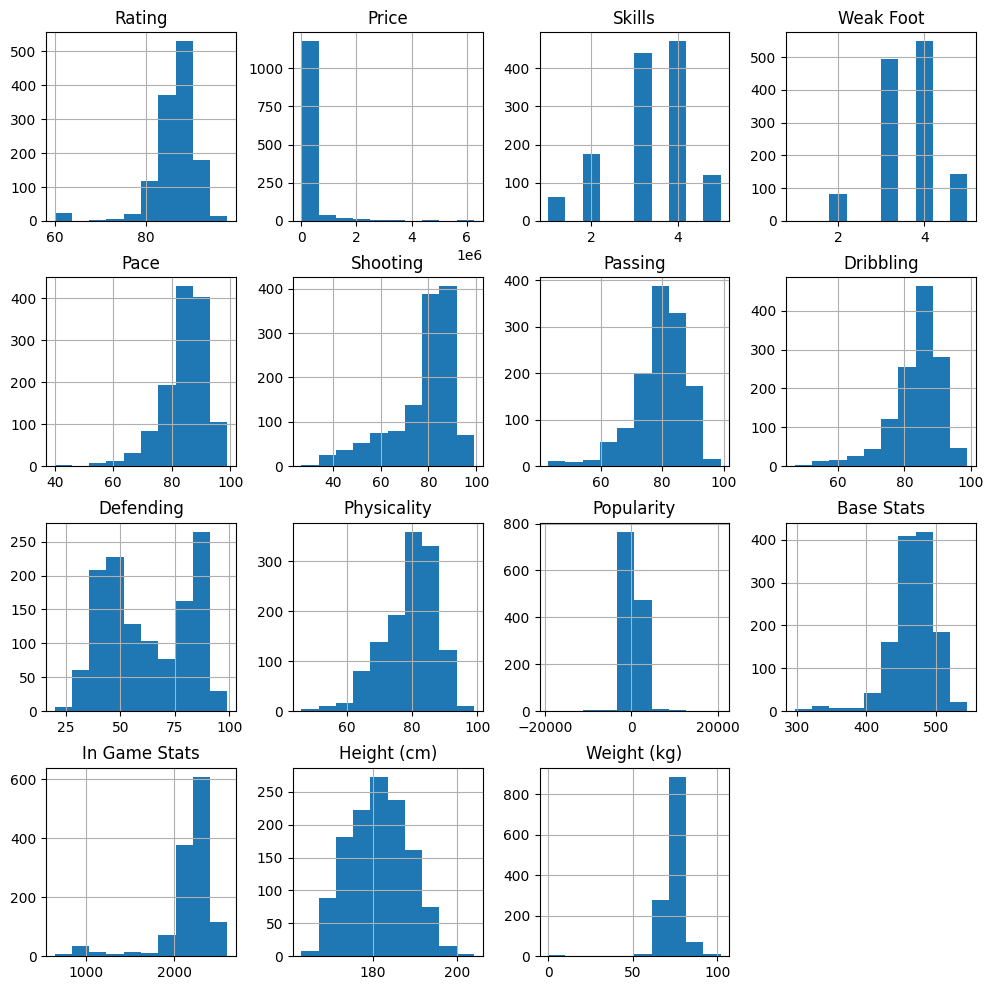

In [113]:
fig, ax = plt.subplots(figsize = (12,12))

num_df_train.hist(ax=ax);

We can see that many of our features are heavily skewed so we will need to fix this. There seems to be an issue with the Weight column containing small values which we will look into:  We also know that popularity should be our only feature with negative values, and this appears to be the case above which is good, but we can check for sure:

In [114]:
# Show minimum weight value
print('Minimum weight value (Train):', num_df_train['Weight (kg)'].min())
print('Minimum weight value (Test):', num_df_test['Weight (kg)'].min())

Minimum weight value (Train): 0.0
Minimum weight value (Test): 59.0


This is clearly an error so we can replace with the mean:

In [115]:
# Replace zero values with the mean:
num_df_train['Weight (kg)'] = num_df_train['Weight (kg)'].replace({0: num_df_train['Weight (kg)'].mean()})

# Show new minimum weight value
print('Minimum weight value:', num_df_train['Weight (kg)'].min())

Minimum weight value: 58.0


This new minimum seems more logical. We can also sense check the max Weight as well as the min and max Heights:

In [116]:
# Show maximum weight values
print('Maximum weight value (Train):', num_df_train['Weight (kg)'].max())
print('Maximum weight value (Test):', num_df_test['Weight (kg)'].max())
print('\n')

# Show minimum height values
print('Minimum height value (Train):', num_df_train['Height (cm)'].min())
print('Minimum height value (Test):', num_df_test['Height (cm)'].min())
print('\n')

# Show maximum height values
print('Maximum height value (Train):', num_df_train['Height (cm)'].max())
print('Maximum height value (Test):', num_df_test['Height (cm)'].max())
print('\n')

Maximum weight value (Train): 102.0
Maximum weight value (Test): 94.0


Minimum height value (Train): 163.0
Minimum height value (Test): 166.0


Maximum height value (Train): 204.0
Maximum height value (Test): 201.0




We also know that many of these features must be capped at 100, so we will make sure none of the features with values over 100 are the ones that should be capped: 

In [117]:
# Get a list of all columns with values over 100:
over100_cols_train = num_df_train.columns[(num_df_train > 100).any()].to_list()
over100_cols_test = num_df_test.columns[(num_df_test > 100).any()].to_list()

print('Columns with values over 100 (Train):', over100_cols_train)
print('Columns with values over 100 (Test):', over100_cols_test)

Columns with values over 100 (Train): ['Price', 'Popularity', 'Base Stats', 'In Game Stats', 'Height (cm)', 'Weight (kg)']
Columns with values over 100 (Test): ['Price', 'Popularity', 'Base Stats', 'In Game Stats', 'Height (cm)']


The above columns are all fine to have values over 100 so there is no issue there.

We will now look into the Popularity feature which we can see has most of the values concentrated around 0:

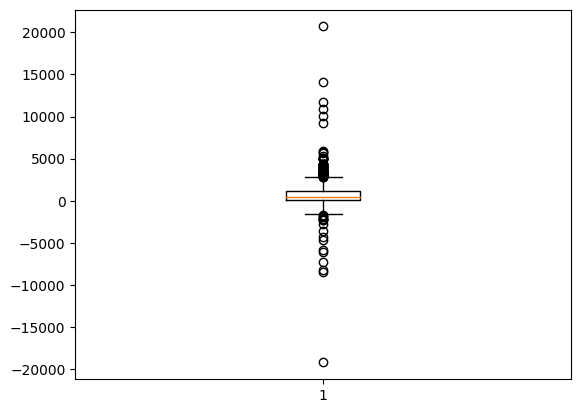

In [118]:
plt.boxplot(num_df_train.Popularity);

Therefore, for this feature it may be best to split it into bins:

In [119]:
# Define the bin edges
bin_edges = [-float('inf'), -1000, -100, -10, 0, 10, 100, 1000, float('inf')]

# Bin the 'Popularity' column using the cut method
num_df_train['Popularity'] = pd.cut(num_df_train['Popularity'], bins=bin_edges, labels=[1,2,3,4,5,6,7,8])
num_df_test['Popularity'] = pd.cut(num_df_test['Popularity'], bins=bin_edges, labels=[1,2,3,4,5,6,7,8])

# Convert to integers
num_df_train['Popularity'] = num_df_train['Popularity'].astype('int')
num_df_test['Popularity'] = num_df_test['Popularity'].astype('int')

We now look into transforming all skewed columns:

In [120]:
# We can view the skew values for each feature
skew_vals = num_df_train.skew().sort_values(ascending=False)
print(skew_vals)

Price            5.922970
Weight (kg)      1.044725
Height (cm)      0.105181
Defending        0.074959
Weak Foot       -0.021454
Skills          -0.405772
Physicality     -0.797045
Passing         -1.143437
Shooting        -1.395138
Pace            -1.413325
Base Stats      -1.420017
Dribbling       -1.497740
Popularity      -1.931044
Rating          -2.378422
In Game Stats   -2.683087
dtype: float64


In [121]:
# We define a skew limit 
skew_limit = 0.75

# We get a list of all the columns with a skew value over this limit
skew_cols = skew_vals[abs(skew_vals) > skew_limit].index.to_list()
print(skew_cols)

['Price', 'Weight (kg)', 'Physicality', 'Passing', 'Shooting', 'Pace', 'Base Stats', 'Dribbling', 'Popularity', 'Rating', 'In Game Stats']


We can then apply a BoxCox transformation to each skewed feature over this limit. However we will first have to add a constant onto Popularity to ensure the values are all positive:

In [122]:
# Box-Cox transform the features:
for feature in skew_cols:
    if feature == 'Price':
        continue

    # apply Box-Cox transformation to training set
    transformed_train, lam = boxcox(num_df_train[feature])
    num_df_train[feature] = pd.Series(transformed_train)
    
    # apply same transformation to test set
    transformed_test = boxcox(num_df_test[feature], lmbda=lam)
    num_df_test[feature] = pd.Series(transformed_test)

In [123]:
# Check the updated skew values
skew_vals = num_df_train.skew().sort_values(ascending=False)
print(skew_vals)

Price            5.922970
Height (cm)      0.105181
Rating           0.088374
Defending        0.074959
Base Stats       0.053054
Weak Foot       -0.021454
Passing         -0.047922
Pace            -0.064779
Physicality     -0.077808
Dribbling       -0.079239
Weight (kg)     -0.079872
In Game Stats   -0.315217
Shooting        -0.339838
Skills          -0.405772
Popularity      -0.564810
dtype: float64


Now that we're happy with our numerical data, we can replace all values in the original dataframe with the updated values:

In [124]:
# Get a list of numerical column names
num_cols = num_df_train.columns.to_list()

# Replace columns in orginal dataframes with updated columns
df_train[num_cols] = num_df_train
df_test[num_cols] = num_df_test

In [125]:
# Overwrite saved datasets
df_train.to_csv(r'datasets\train_dataset.csv', index=False)
df_test.to_csv(r'datasets\test_dataset.csv', index=False)

Although we have significantly reduced our dataset, we should still have enough data to create a model, and this model should now perform better on higher-valued players. 

## 4. Feature Selection

### Imports

In [178]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import pickle

In [179]:
# Load datasets
df_train = pd.read_csv(r'datasets\train_dataset.csv')
df_test = pd.read_csv(r'datasets\test_dataset.csv')

We now have a training a test datset ready to to build a model. However, we have a lot of features so we will likely have an overfit model as it stands. Therefore we will need to reduce our number of features.

We can first build and evaluate a basic model to act as our baeline: 

In [180]:
# We split our training dataset further into a training a validation set to avoid data leakage: 
df_train_val, df_test_val = train_test_split(df_train, test_size=0.2, random_state=42)

# Define X and y
X_train_val = df_train_val.drop(['Price'], axis=1)
X_test_val = df_test_val.drop(['Price'], axis=1)

y_train_val = df_train_val['Price']
y_test_val = df_test_val['Price']

In [181]:
# Create and fit model
rf = RandomForestRegressor()
rf.fit(X_train_val, y_train_val)

# Make predictions
y_pred = rf.predict(X_test_val)

# Evaluate
r2 = r2_score(y_test_val, y_pred)
print('R2 Score:', r2)

R2 Score: 0.5182466122875551


This is a pretty bad performance metric but we should be able to increase it through reducing our number of features. We will intially do this by reducing any feature that doesn't correlate sufficiently with our target variable Price.

In [182]:
# View correlation values
top_corr_vals = abs(df_train_val.corr()['Price']).sort_values(ascending=False)
print(top_corr_vals.head(20))

Price                 1.000000
Rating                0.481858
Dribbling             0.334290
Base Stats            0.312157
In Game Stats         0.309657
Passing               0.288767
Team_paris sg         0.285507
Pace                  0.262575
Skills                0.258870
Team_Other            0.254120
Shooting              0.246417
Weak Foot             0.230601
Team_fut icons        0.218905
League_icons          0.218905
Card Type_if          0.207927
Card Type_icon        0.160509
Popularity            0.148952
League_rem_eur_div    0.101327
WR_Att_OE             0.099537
LW                    0.093860
Name: Price, dtype: float64


Since all of our features have fairly low correlations values with our target variable, we will set our limit fairly low:

In [183]:
# Set a correlation limit
corr_limit = 0.2

# Get a list of features with a correlation over corr_limit
corr_over_lim = top_corr_vals[top_corr_vals > corr_limit].index.to_list()
corr_over_lim.remove('Price')

# Reduce features of df_train and df_test
X_train_val2 = X_train_val[corr_over_lim]
X_test_val2 = X_test_val[corr_over_lim]

# Show previous and new number of features
print('Previous number of features:', X_train_val.shape[1])
print('New number of features:', X_train_val2.shape[1])

Previous number of features: 81
New number of features: 14


We will also reduce one of any two features that have a correlation with one another of over 0.8

In [184]:
# Define colinearity limit 
colin_limit = 0.8

# Create a correlation matrix
corr_matrix = X_train_val2.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > colin_limit)]

# Drop the highly correlated features
X_train_val3 = X_train_val2.drop(to_drop, axis=1)
X_test_val3 = X_test_val2.drop(to_drop, axis=1)

# Show previous and new number of features
print('Previous number of features:', X_train_val2.shape[1])
print('New number of features:', X_train_val3.shape[1])

# Show dropped columns
print('Dropped features:', to_drop)

Previous number of features: 14
New number of features: 13
Dropped features: ['League_icons']


We can rerun our baseline model to see if we get better results:

In [185]:
# Create and fit model
rf = RandomForestRegressor()
rf.fit(X_train_val3, y_train_val)

# Make predictions
y_pred = rf.predict(X_test_val3)

# Evaluate
r2 = r2_score(y_test_val, y_pred)
print('R2 Score:', r2)

R2 Score: 0.5714809669861545


We can see that this has marginally improved the score, but we can build a function that will allow us to compare performance scores:

In [186]:
def test_colin_limits(df_train_val, df_test_val, corr_limit, colin_limit):

    # Find top correlation values   
    top_corr_vals = abs(df_train_val.corr()['Price']).sort_values(ascending=False)

    # Get a list of features with a correlation over corr_limit
    corr_over_lim = top_corr_vals[top_corr_vals > corr_limit].index.to_list()

    # Reduce features of df_train and df_test
    df_train_val2 = df_train_val[corr_over_lim]
    df_test_val2 = df_test_val[corr_over_lim]

    # Create a correlation matrix
    corr_matrix = df_train_val2.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than 0.8
    to_drop = [column for column in upper.columns if any(upper[column] > colin_limit)]

    # Drop the highly correlated features
    df_train_val3 = df_train_val2.drop(to_drop, axis=1)
    df_test_val3 = df_test_val2.drop(to_drop, axis=1)

    # Define X and y
    X_train = df_train_val3.drop('Price', axis=1)
    X_test = df_test_val3.drop('Price', axis=1)

    y_train = df_train_val3['Price']
    y_test = df_test_val3['Price']

    # Create and fit model
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf.predict(X_test)

    # Evaluate
    r2 = r2_score(y_test, y_pred)

    return r2

We then run this on a range of correlation and colinearity thresholds and find the best performing combination:

In [187]:
# Create a range of correlation and colinearity limits:
corr_lims = np.linspace(0.1, 0.3, 21)
colin_lims = np.linspace(0.5,1,11)

# Create am empty dictionary to store values
r2_dict = {}

# Loop through limits and add values to the dictionary
for corr in corr_lims:
    r2_scores = []
    num_feat_removed = [] 
    for colin in colin_lims:
        r2 = test_colin_limits(df_train, df_test, corr_limit, colin)
        r2_scores.append(r2)
    r2_dict[corr] = r2_scores


In [188]:
# Create a dataframe of r2 scores
r2_df = pd.DataFrame(r2_dict, index=colin_lims)

# Find the highest r2 score and its location in the dataframe
highest_r2 = r2_df.values.max()
highest_r2_loc = np.unravel_index(r2_df.values.argmax(), r2_df.shape)

# Get the values of the optimal correlation and colinearity limits
best_corr_lim = corr_lims[highest_r2_loc[1]]
best_colin_lim = colin_lims[highest_r2_loc[0]]

print(f'The highest R2 value is {highest_r2:.3f} when the correlation limit is {best_corr_lim:.2f} and colinearity limit is {best_colin_lim:.2f}')


The highest R2 value is 0.538 when the correlation limit is 0.13 and colinearity limit is 0.65


This is a good increase in performance so we will apply these limits before looking into building and tuning some additional models

In [189]:
# Load datasets again:
df_train = pd.read_csv(r'datasets\train_dataset.csv')
df_test = pd.read_csv(r'datasets\test_dataset.csv')

In [190]:
# Set correlation and colin limits:
corr_limit = best_corr_lim
colin_limit = best_colin_lim

# Get a list of features with a correlation over corr_limit
corr_over_lim = top_corr_vals[top_corr_vals > corr_limit].index.to_list()

# Reduce features of df_train and df_test
df_train2 = df_train[corr_over_lim]
df_test2 = df_test[corr_over_lim]

# Create a correlation matrix
corr_matrix = df_train2.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > colin_limit)]

# Drop the highly correlated features
df_train3 = df_train2.drop(to_drop, axis=1)
df_test3 = df_test2.drop(to_drop, axis=1)

# Show previous and new number of features
print('Previous number of features:', df_train.shape[1]-1)
print('New number of features:', df_train3.shape[1]-1)

# Show remaining features
rem_features = df_train3.columns.to_list()
rem_features.remove('Price')
print('\n')
print('Remaining features:', rem_features)


Previous number of features: 81
New number of features: 11


Remaining features: ['Rating', 'Dribbling', 'Base Stats', 'Team_paris sg', 'Pace', 'Skills', 'Team_Other', 'Weak Foot', 'Team_fut icons', 'Card Type_if', 'Popularity']


In [191]:
df_train3.to_csv(r'datasets\train_dataset_reduced_features.csv', index=False)
df_test3.to_csv(r'datasets\test_dataset_reduced_features.csv', index=False)

We have removed quite a lot of features so we can always go back and reduce out correlation and colinearity limits, but for now we can try building different models.

## 5. Model Building and Evaluation

### Import Libraries

In [192]:
import optuna
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [193]:
# Load data
df_train = pd.read_csv(r'datasets\train_dataset_reduced_features.csv')
df_test = pd.read_csv(r'datasets\test_dataset_reduced_features.csv')

In [194]:
# Define X and y 
X_train = df_train.drop(['Price'], axis=1)
X_test = df_test.drop(['Price'], axis=1)

y_train = df_train['Price']
y_test= df_test['Price']

We cun use Optuna to build an Elastic Net model

In [195]:
def objective(trial):
    # Define hyperparameter ranges for the Elastic Net model
    params = {
        'alpha': trial.suggest_loguniform('alpha', 1e-6, 10),
        'l1_ratio': trial.suggest_uniform('l1_ratio', 0, 1),
        'max_iter': trial.suggest_int('max_iter', 100, 1000, step=100),
        'tol': trial.suggest_loguniform('tol', 1e-6, 1e-2)
    }
    
    # Train the Elastic Net model using cross-validation and return the average R2 score
    en = ElasticNet(**params)
    scores = cross_val_score(en, X_train, y_train, cv=5, scoring='r2')
    r2_mean = scores.mean()
    return r2_mean

study1 = optuna.create_study(direction='maximize')
study1.optimize(objective, n_trials=200)

[I 2023-05-02 18:36:03,220] A new study created in memory with name: no-name-c771ede6-559d-42c9-9316-cfda7e1ff721
[I 2023-05-02 18:36:03,300] Trial 0 finished with value: 0.24477882325158418 and parameters: {'alpha': 9.260458340095713, 'l1_ratio': 0.446819592249442, 'max_iter': 100, 'tol': 1.722207186724377e-06}. Best is trial 0 with value: 0.24477882325158418.
[I 2023-05-02 18:36:03,439] Trial 1 finished with value: 0.24705564993162313 and parameters: {'alpha': 4.2985242745985, 'l1_ratio': 0.664364683878444, 'max_iter': 600, 'tol': 0.0013194365276477567}. Best is trial 1 with value: 0.24705564993162313.
[I 2023-05-02 18:36:03,582] Trial 2 finished with value: 0.2806748058073057 and parameters: {'alpha': 0.002029455114660197, 'l1_ratio': 0.8747826913763881, 'max_iter': 1000, 'tol': 4.609198651399722e-05}. Best is trial 2 with value: 0.2806748058073057.
[I 2023-05-02 18:36:03,703] Trial 3 finished with value: 0.28147845505452673 and parameters: {'alpha': 0.0010068028570632754, 'l1_ratio

In [196]:
# Define random forest regressor with optimised hyperparameters
en = ElasticNet(alpha=study1.best_params['alpha'],
                            l1_ratio=study1.best_params['l1_ratio'],
                            max_iter=study1.best_params['max_iter'],
                            tol=study1.best_params['tol'],
                            random_state=42)

# Fit the regressor with the training data
en.fit(X_train, y_train)

# Make predictions on the test data
y_pred = en.predict(X_test)

# Evaluate the performance of the model using, mean absolute error, root mean squared error and R2 score
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R2 Score: {r2:.4f}')

Mean Absolute Error: 328543.60
Root Mean Squared Error: 1001395.31
R2 Score: 0.1898


In [197]:
scores_dict = {'Elastic Net' : [r2.round(4), rmse.round(2), mae.round(2)]}

We can use Optuna to tune our hyperparameters for a Random Forest model:

In [198]:
# Define objective function for hyperparameter optimisation
def objective(trial):
    # Define hyperparameters to be optimized
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 50, 100),
        'max_depth' : trial.suggest_int('max_depth', 2, 10),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 5)
    }
    
    # Create an XGBoost regressor model with the given hyperparameters
    model = RandomForestRegressor(**param)

    # Compute cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    # Calculate the mean R2 score across cross-validation folds
    return cv_scores.mean()

# Create an Optuna study and run the trials
study2 = optuna.create_study(direction='maximize') # Optimize for maximum R2 score
study2.optimize(objective, n_trials=200)

[I 2023-05-02 18:36:26,276] A new study created in memory with name: no-name-0cc5ebcf-ef3b-4daf-a8e5-42f6811a8aee
[I 2023-05-02 18:36:26,666] Trial 0 finished with value: 0.4124262492150709 and parameters: {'n_estimators': 58, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.4124262492150709.
[I 2023-05-02 18:36:27,456] Trial 1 finished with value: 0.4823040684344712 and parameters: {'n_estimators': 94, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.4823040684344712.
[I 2023-05-02 18:36:28,686] Trial 2 finished with value: 0.47909509373174625 and parameters: {'n_estimators': 98, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.4823040684344712.
[I 2023-05-02 18:36:29,200] Trial 3 finished with value: 0.45695041205464754 and parameters: {'n_estimators': 66, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.48

Now we can fit the model with the optimised parameters:

In [199]:
# Define random forest regressor with optimised hyperparameters
rf = RandomForestRegressor(n_estimators=study2.best_params['n_estimators'],
                            max_depth=study2.best_params['max_depth'],
                            min_samples_split=study2.best_params['min_samples_split'],
                            min_samples_leaf=study2.best_params['min_samples_leaf'],
                            random_state=42)

# Fit the regressor with the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Evaluate the performance of the model using, mean absolute error, root mean squared error and R2 score
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R2 Score: {r2:.4f}')

Mean Absolute Error: 179327.94
Root Mean Squared Error: 793464.51
R2 Score: 0.4913


In [200]:
scores_dict['Random Forest'] = [r2.round(4), rmse.round(2), mae.round(2)]

In [213]:
# Define objective function for hyperparameter optimisation
def objective(trial):

    # Define hyperparameters to be optimised
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'objective': 'reg:squarederror',
        'random_state': 42
    }


    # Create an XGBoost regressor model with the given hyperparameters
    model = XGBRegressor(**param)

    # Compute cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    # Calculate the mean R2 score across cross-validation folds
    return cv_scores.mean()

# Create an Optuna study and run the trials
study3 = optuna.create_study(direction='maximize') # Optimise for maximum R2 score
study3.optimize(objective, n_trials=200)

[I 2023-05-02 18:43:43,648] A new study created in memory with name: no-name-8361ccc9-b97d-45ac-a3a7-30d42d5e78fc
[I 2023-05-02 18:43:43,861] Trial 0 finished with value: 0.518163068391032 and parameters: {'n_estimators': 70, 'max_depth': 3, 'learning_rate': 0.09641954414819025, 'subsample': 0.5352329224834225, 'colsample_bytree': 0.9717340186456291, 'min_child_weight': 7}. Best is trial 0 with value: 0.518163068391032.
[I 2023-05-02 18:43:44,380] Trial 1 finished with value: 0.41301977992767885 and parameters: {'n_estimators': 94, 'max_depth': 8, 'learning_rate': 0.09844785735966585, 'subsample': 0.936288450464778, 'colsample_bytree': 0.8861638715512876, 'min_child_weight': 2}. Best is trial 0 with value: 0.518163068391032.
[I 2023-05-02 18:43:44,553] Trial 2 finished with value: 0.4949572708525089 and parameters: {'n_estimators': 78, 'max_depth': 2, 'learning_rate': 0.07327588889639614, 'subsample': 0.8613166660458385, 'colsample_bytree': 0.5879971770888494, 'min_child_weight': 1}. B

In [214]:
# Define random forest regressor with optimized hyperparameters
xgb = XGBRegressor(
                            n_estimators = study3.best_params['n_estimators'],
                            max_depth = study3.best_params['max_depth'],
                            learning_rate = study3.best_params['learning_rate'],
                            subsample = study3.best_params['subsample'],
                            colsample_bytree = study3.best_params['colsample_bytree'],
                            min_child_weight = study3.best_params['min_child_weight'],
                            random_state=42
)

# Fit the regressor with the training data
xgb.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb.predict(X_test)

# Evaluate the performance of the model using, mean absolute error, root mean squared error and R2 score
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R2 Score: {r2:.4f}')

Mean Absolute Error: 176508.32
Root Mean Squared Error: 753967.36
R2 Score: 0.5407


In [215]:
scores_dict['XGBoost'] = [r2.round(4), rmse.round(2), mae.round(2)]

We can compare our performance metrics below:

In [216]:
# Create a dataframe from the dictionary
scores_df = pd.DataFrame(scores_dict, index = ['r2', 'rmse', 'mae'])
scores_df

,Elastic Net,Random Forest,XGBoost
r2,1.898000e-01,0.4913,0.5407
rmse,1.001395e+06,793464.5100,753967.3600
mae,3.285436e+05,179327.9400,176508.3200


We can see that XGBoost slightly outperformed Random Forest and both significantly outperformed Elastic Net. 

We can save our model and our predicted values for further analysis:

In [217]:
# Save a dataframe of predictions and true values
prediction_comparison = pd.DataFrame(y_pred, y_test).rename(columns={'Price' : 'True Price', 0 : 'Predicted Price'}).reset_index()
prediction_comparison.to_csv(r'datasets\prediction_comparison.csv', index=False)

# Save trained model to file using pickle
with open(r'model\xgbmodel.pkl', 'wb') as f:
    pickle.dump(xgb, f)

# 6. Model Analysis

### Import Libraries

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [219]:
# Load data
df_test = pd.read_csv(r'datasets\test_dataset_reduced_features.csv')
df_train = pd.read_csv(r'datasets\train_dataset_reduced_features.csv')

We can do some deeper analysis into the model so identify its shortcomings and see whether any valuable insights can be gained. 

We first can plot a scatter graph of out predicted results against the true values: 

In [220]:
# Load predictions
prediction_comparison = pd.read_csv(r'datasets\prediction_comparison.csv')
y_test = prediction_comparison['Price']
y_pred = prediction_comparison['Predicted Price']

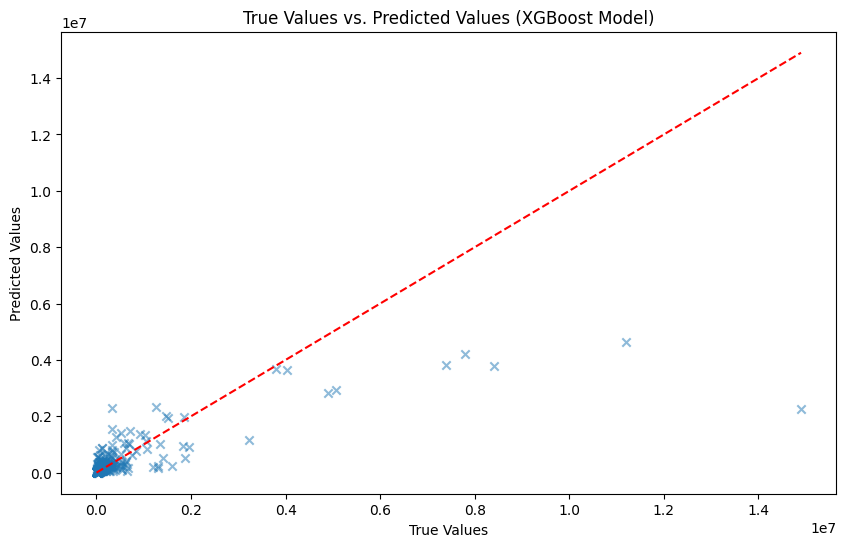

In [221]:
# Scatter graph for the XGBoost predictions:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_test, y_pred, marker='x', alpha=0.5)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')
ax.set_title('True Values vs. Predicted Values (XGBoost Model)');

We can see above that the model has under-valued the most highly-priced players. 

If we only look at players who have a true value of under 100k, we can also see that the model is massively over-valuing these players:

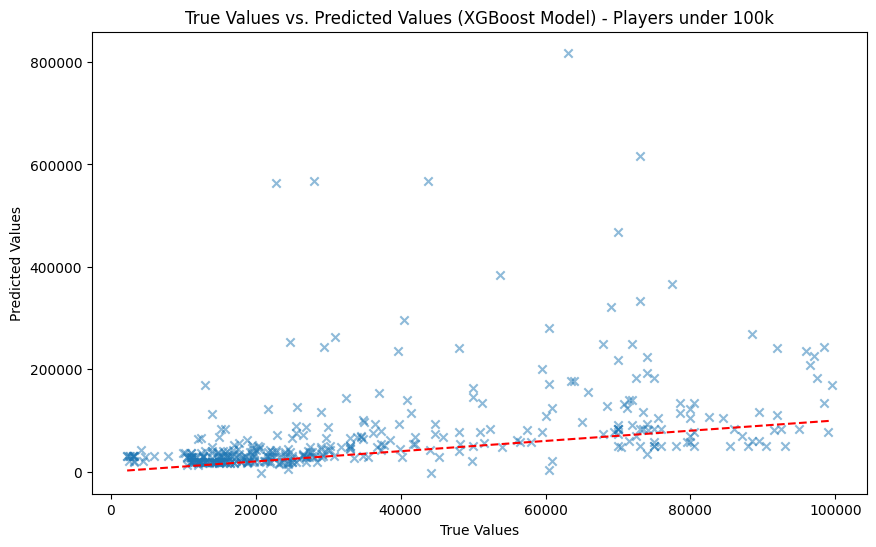

In [222]:
# Scatter graph for the XGBoost predictions:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_test[y_test < 1e5], y_pred[y_test < 1e5], marker='x', alpha=0.5)
ax.plot([y_test[y_test < 1e5].min(), y_test[y_test < 1e5].max()], [y_test[y_test < 1e5].min(), y_test[y_test < 1e5].max()], 'r--')
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')
ax.set_title('True Values vs. Predicted Values (XGBoost Model) - Players under 100k');

We can also look into the most important features for predicting price according to our model:

In [223]:
# Load the model
with open(r'model\xgbmodel.pkl', 'rb') as file:
    # load the model
    model = pickle.load(file)

# Define X_train
X_train = df_train.drop('Price', axis=1)

Text(0.5, 1.0, 'Feature Importances')

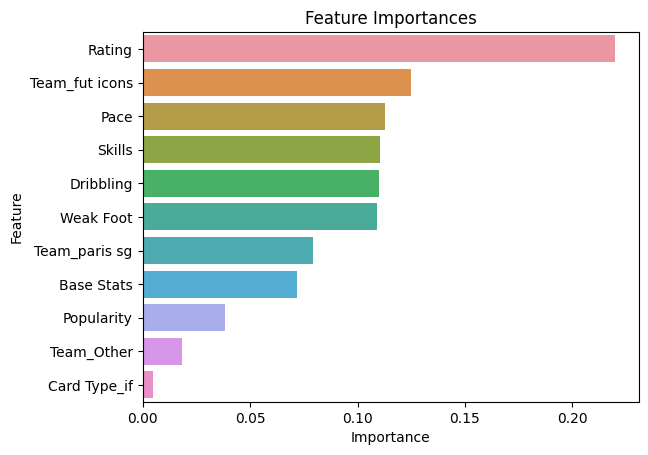

In [224]:
# Get feature importances based on gain
importances = model.feature_importances_

feature_names = X_train.columns

# Create a dataframe of feature importances
df_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort the dataframe by importance in descending order
df_importances = df_importances.sort_values('importance', ascending=False)

# Create a barplot of feature importances
sns.barplot(x='importance', y='feature', data=df_importances)

# Add labels and title
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')

# 7. Conclusion

In conclusion, we built a regression model to predict FIFA Ultimate Team player marketplace prices. Unfortunately the model only performed moderately well with an R2 score of 0.54, and it tended to undervalue expensive players and overvalue cheaper players. The extremely skewed distribution of the target variable was likely one reason for the model underperforming, with the abundance of players on the lower end of the price spectrum very hard to predict. Player prices can also be randomly influenced by events outside the player's sttributes such as through real-world events or a current live squad building challenge that may require that player, so a better performing model would likely have to take events such as these into account. Additionally, one of the major factors likely resposible for a player's price is the rarity of that card in the marketplace, and unfortunately this was not some a piece of data that was readily available.

The mean absolute error (MAE) of 176,508 coins suggests that the model is not precise enough to identify good value deals in the FIFA Ultimate Team player marketplace, given that this amount error margin is more than most players can afford. As a result, relying solely on this model to make buying or selling decisions in the marketplace would likely lead to poor outcomes. A better model with a lower MAE and a higher R-squared score would be necessary to accurately predict player prices and find good value deals.

Despite the limitations, we can still draw some valuable insights from the model. For example, we found that player attributes such as overall rating, pace, and dribbling were strong predictors of player prices, which was to be expected given that these are generally the most sought after qualities in a player. Additionally, we can can see that playing for Paris Saint Germain can be highly correlated with the price of a player, which is likely due to this team containing several high-rated players with extremely large fanbases such as Lionel Messi, Kylian Mbappé and Neymar, so there an argument could be made that value in the marketplace can be better found outside of this team. 

In conclusion, while our model did not perform as well as we had hoped, we gained valuable experience in working with real-world datasets and learned some valuable insights into the FIFA Ultimate Team player marketplace. Future work could include obtaining data on card rarity to improve the model's accuracy and exploring other modeling techniques that may better capture the complexities of player pricing.